In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Capítulo 2 - Pojeto de Aprendizado de Maquina Ponta à Ponta

- Atividades feitas ao longo deste notebook:
    1. Obter os dados
    2. Indentificar e visualizar os dados para obter informações úteis
    3. Preparar os dados para algoritmos do aprendizado de máquina
    4. Selecionar e treinar um modelo
    5. Aperfeiçoar o modelo
    6. Apresentar a solução

    
&nbsp;_Os dados usados serão o conjunto de dados dos preços dos imóveis da California com base no censo de 1990_

- Obtendo os dados

In [15]:
from pathlib import Path
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [18]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


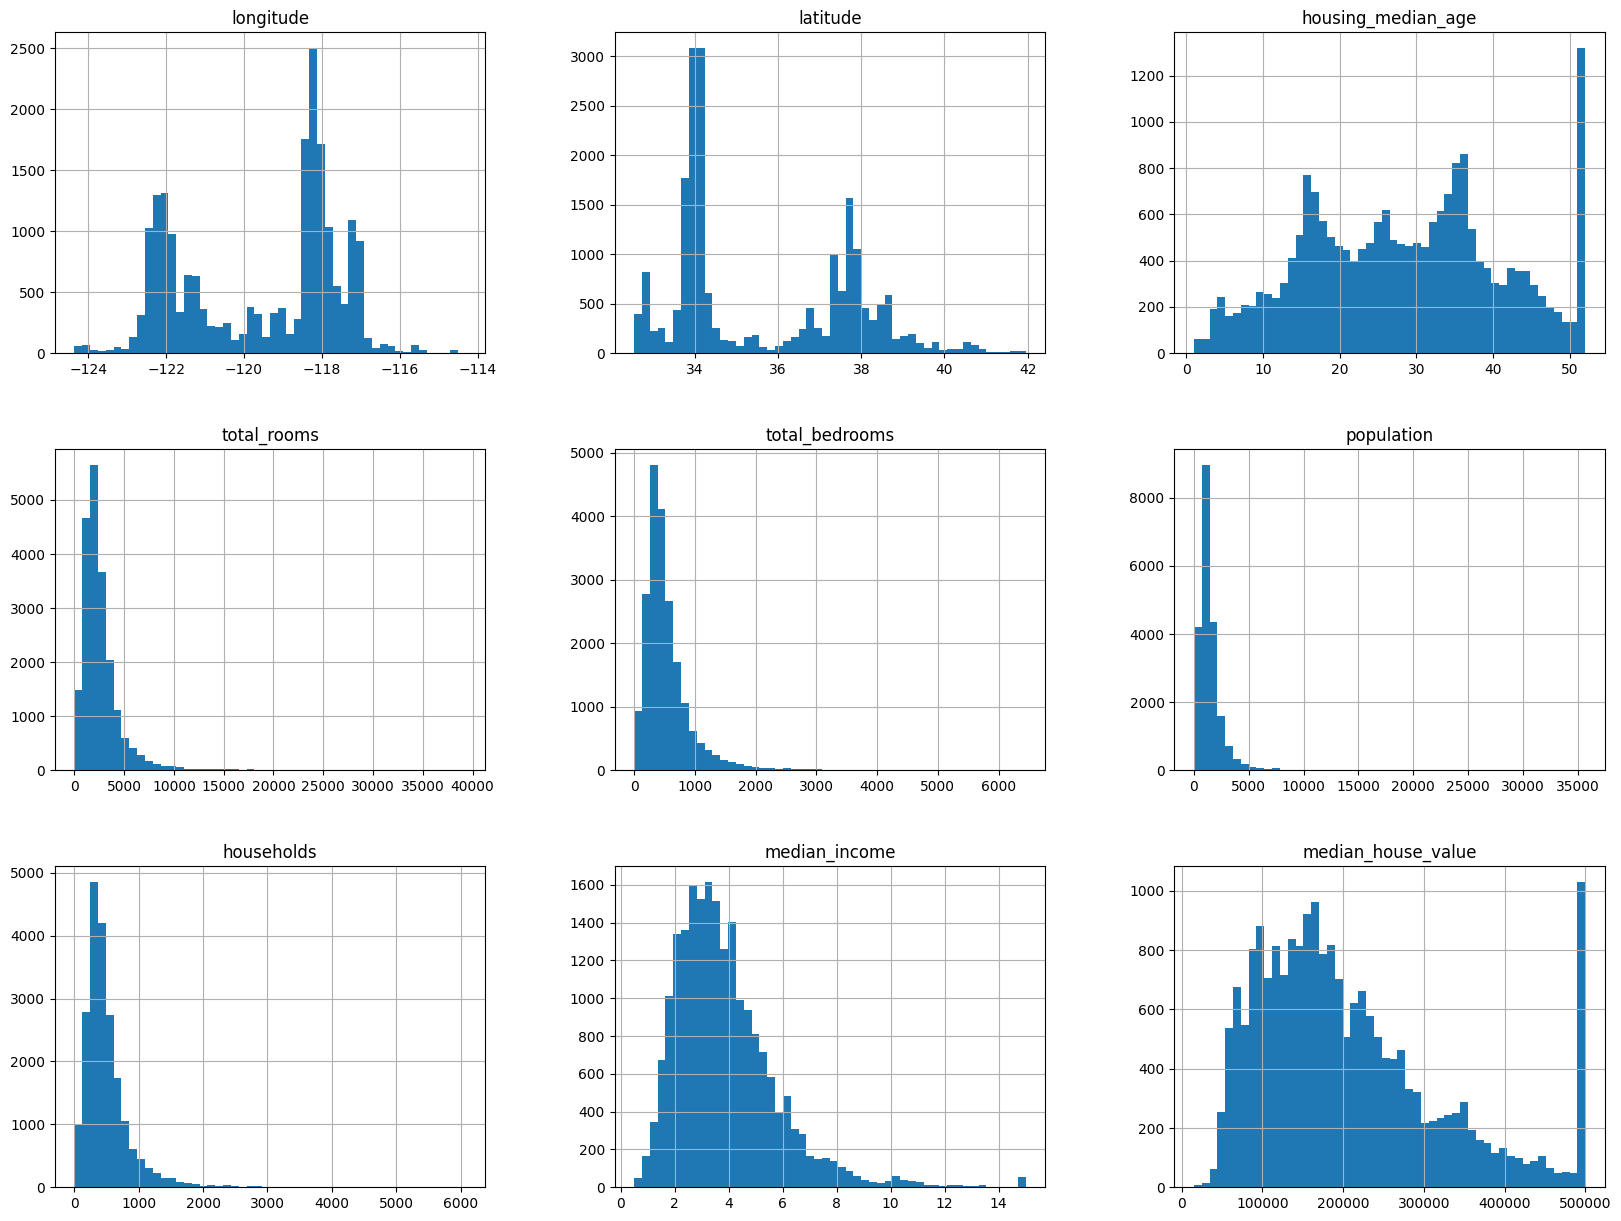

In [19]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

- Criando um conjunto de testes

In [20]:
def split_train_test(data, test_ratio):
    shuffed_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indeces = shuffed_indices[:test_set_size]
    train_indeces = shuffed_indices[test_set_size:]
    return data.iloc[train_indeces], data.iloc[test_indeces]

train_set, test_set = split_train_test(housing, 0.2)
print(f"train_set: {len(train_set)}, test_set: {len(test_set)}")

train_set: 16512, test_set: 4128


In [21]:
# Dividindo um conjunto de dados em conjuntos de treinamento e
# teste com base em um critério específico, onde o critério é
# calcular um valor de verificação CRC32 a partir de um identificador
# e compará-lo com uma taxa de teste especificada. Isso permite a
# divisão dos dados de maneira consistente entre diferentes execuções,
# mantendo uma proporção de teste fixa.

# Importando a função crc32 da biblioteca de compactação zlib. O crc32 é
# um algoritmo de verificação de redundância cíclica (CRC) usado para
# calcular um valor de verificação de um dado.
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

# fazenso uso do indece de linha como id
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # adiciona um index à coluna
# Usando a latitude e a longitude de uma região para combinar com o ID
housing_with_id["id"] = housing["longitude"] * 1e3 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [22]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [23]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


In [24]:
# Usando train_test_split do Scikit-Learn, a qual tem o mesmo
# proposito da função spilt_train_test() criada anteriomente

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [25]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,291000.0,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,156100.0,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,353900.0,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,241200.0,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,53800.0,INLAND


In [26]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,286100.0,<1H OCEAN


<Axes: >

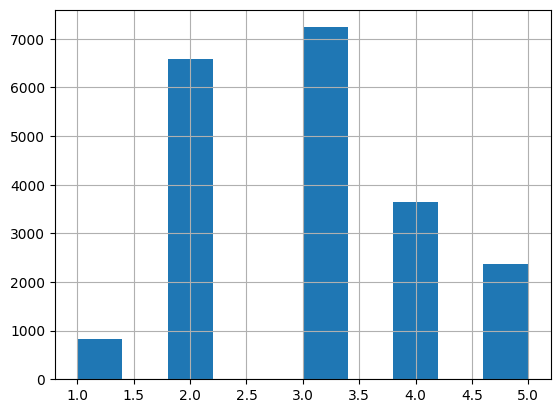

In [27]:
# Criando um atributo de categoria de renda com cinco categorias (1 a 5)
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], # $1.5k... $6k
                               labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()

In [28]:
# Fazendo uma amostragem estratificada com base na categoria de renda

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [29]:
# Proporções da categorio de renda do conjunto de teste
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [30]:
# Proporções da categorio de renda do conjunto de treinamento
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [31]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.042393,6.447689,0.364964
2,0.318847,0.318798,0.307413,-3.586081,-0.015195
3,0.350581,0.350533,0.345203,-1.533997,-0.013820
4,0.176308,0.176357,0.184109,4.424292,0.027480
5,0.114438,0.114341,0.120882,5.630821,-0.084674


In [32]:
# Removendo o atributo income_cat para que os dados voltem ao estado original
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

- Explorando e visualizando os dados para obter informações úteis

In [33]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

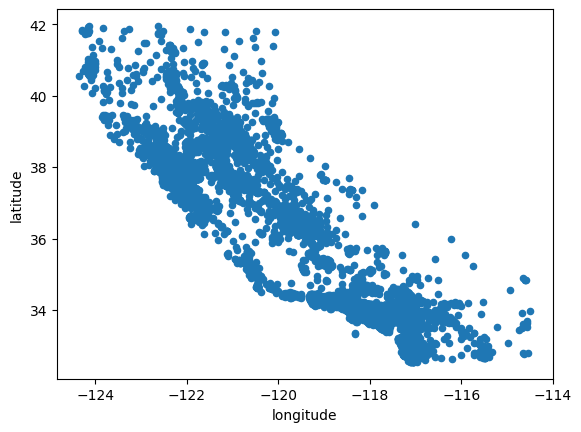

In [34]:
housing.plot(kind='scatter', x='longitude', y='latitude')

<Axes: xlabel='longitude', ylabel='latitude'>

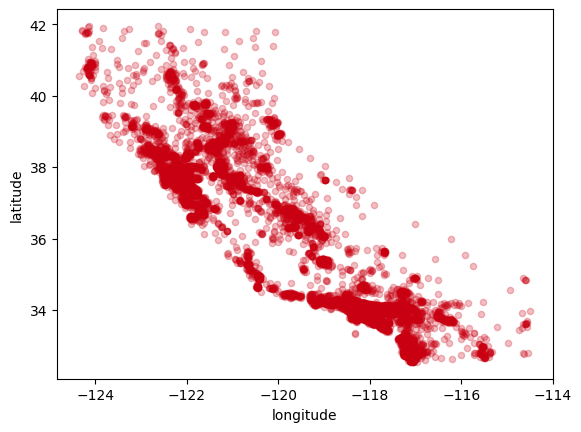

In [35]:
housing.plot(kind='scatter', color='#C90011', x='longitude', y='latitude', alpha=0.25)

<Axes: xlabel='longitude', ylabel='latitude'>

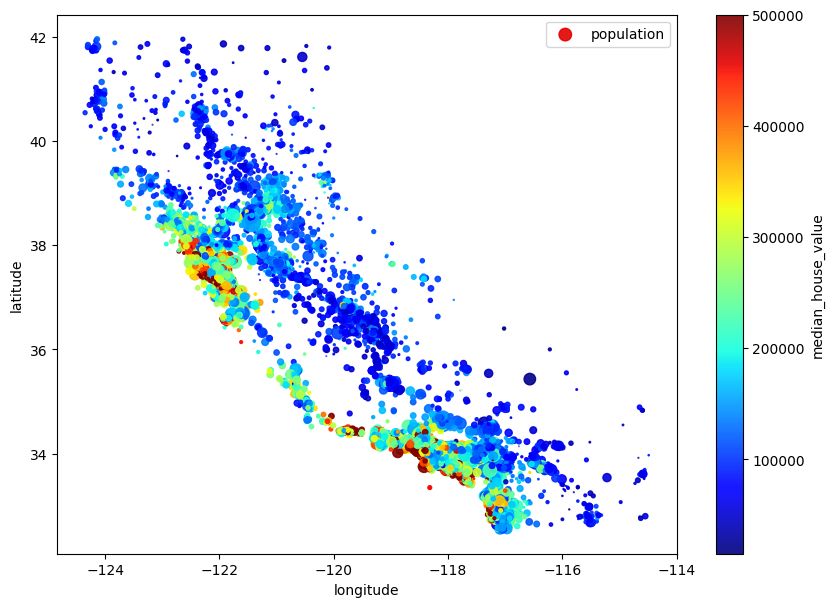

In [36]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.9,
             s=housing['population']/100, label='population', figsize=(10,7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
             legend=True)

- Buscando correlações

In [37]:
housing = housing.drop(columns='ocean_proximity')
corr_matrix = housing.corr() # coeficiente de correlação padrão
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

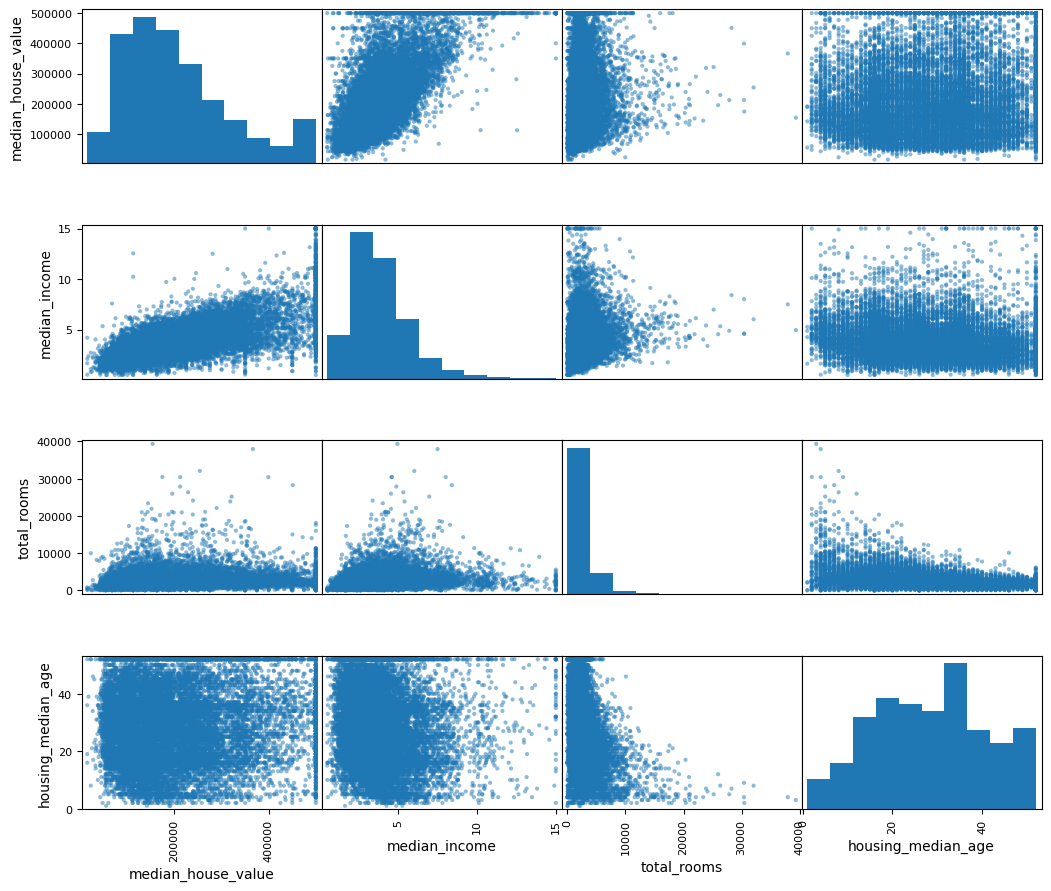

In [38]:
from pandas.plotting import scatter_matrix

atttributes = ['median_house_value', 'median_income', 'total_rooms',
               'housing_median_age']
scatter_matrix(housing[atttributes], figsize=(12, 20))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.5, hspace=0.4)

<Axes: xlabel='median_income', ylabel='median_house_value'>

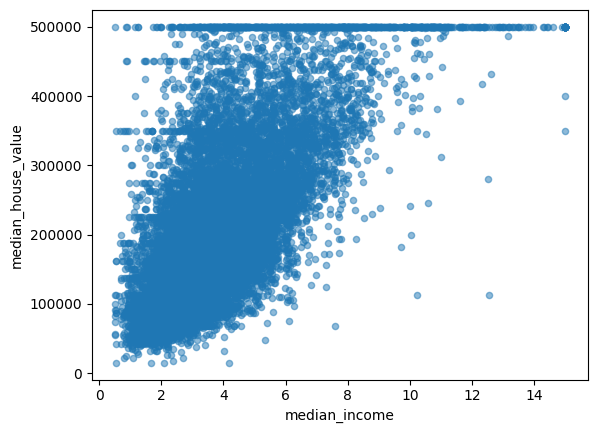

In [39]:
housing.plot(kind='scatter', x='median_income',
             y='median_house_value', alpha=0.5)

- Testando combinações de atributos

In [40]:
# Criando novos atributos
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

### _Preparando os dados para algoritmos de aprendizado de máquina_

In [41]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

- Limpando os dados

In [42]:
from sklearn.impute import SimpleImputer

housing.dropna(subset=['total_bedrooms'])
housing_num = housing.drop(columns="ocean_proximity")
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [43]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [44]:
# usando o imputer para transformar o conjunto de treinamento
# substituindo os valores ausentes pelas médias aprendidas
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


- Manipulando texto e atributos categóricos

In [45]:
housing_cat = housing[["ocean_proximity"]]
housing_cat

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
...,...
14207,<1H OCEAN
13105,INLAND
19301,NEAR OCEAN
19121,<1H OCEAN


In [46]:
# Realizando a conversão das categorias de 'ocean_proximity' de texto
# para número
from sklearn.preprocessing import OrdinalEncoder

ordianl_encoder = OrdinalEncoder()
housing_cat_encoder = ordianl_encoder.fit_transform(housing_cat)
housing_cat_encoder

array([[3.],
       [0.],
       [1.],
       ...,
       [4.],
       [0.],
       [4.]])

In [47]:
ordianl_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [48]:
# Convertendo os valores categóricos em vetores one-hot
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

- Customizando os tranformadores

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [50]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

In [51]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
13096,-122.42,37.8,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,3.211799,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,5.504202,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.433,INLAND,5.334975,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,5.351282,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,3.725256,1.631399


- Transformação de Pipelines

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.42303652,  1.0136059 ,  1.86111875, ..., -0.86602737,
        -0.33020372,  1.84662439],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.0245495 ,
        -0.25361631, -0.5081207 ],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.04119332,
        -0.05104091, -0.20215476],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ..., -0.10998748,
         0.15854151, -0.24249175],
       [ 0.58639727, -0.73960483,  0.66925745, ..., -0.36093745,
        -0.21033248,  0.25977479],
       [-1.41803793,  0.94797769,  1.22545939, ..., -1.32397227,
         0.04958379,  3.61270996]])

In [53]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipelines = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipelines.fit_transform(housing)
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

- Treinando e avaliando o conjunto de treinamento

In [54]:
# Usando o modelo de regressão linear
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipelines.transform(some_data)

print("Prediction:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Prediction: [276608.27419651 333603.0303772  118237.5726011  108255.75159886
 308943.82732346]
Labels: [458300.0, 483800.0, 101700.0, 96100.0, 361800.0]


In [55]:
# Calculando o RMSE (o desvio padrão dos valores residuais, ou seja, os erros de previsão)
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

67769.12117461127

In [56]:
# Usando um modelo mais complexo e poderoso para realizar o treinamento,
# DecisionTreeRegressor, o qual é capaz de identificar relacionamentos
# não lineares complexos nos dados

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                               squared=False)
tree_rmse

0.0

- Avaliando melhor com a validação cruzada

In [57]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([68024.50308541, 67081.0628766 , 68770.83959234, 73280.05806018,
       68113.99282244, 73007.28022936, 73041.26503719, 72202.8269347 ,
       69446.50189863, 70266.49098589])

In [58]:
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     70323.482152
std       2374.069776
min      67081.062877
25%      68278.204515
50%      69856.496442
75%      72806.166906
max      73280.058060
dtype: float64

In [59]:
def display_score(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

display_score(tree_rmse_scores)

Scores:  [68024.50308541 67081.0628766  68770.83959234 73280.05806018
 68113.99282244 73007.28022936 73041.26503719 72202.8269347
 69446.50189863 70266.49098589]
Mean:  70323.48215227426
Standard deviation:  2252.240345159401


In [60]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_score(lin_rmse_scores)

Scores:  [69717.57852026 66650.26617871 66488.43193213 70478.22519838
 66837.93229332 68220.31091521 66922.70445332 69700.47781664
 67122.26131607 67802.47918508]
Mean:  67994.06678091262
Standard deviation:  1394.937701550329


In [61]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18500.845182815105

In [62]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_score(forest_rmse_scores)

Scores:  [48762.28825918 49969.19049146 47573.54522961 50546.87486609
 48864.10555209 49823.40502798 50329.34328877 51257.57472672
 49940.74542084 49433.48950508]
Mean:  49650.05623678271
Standard deviation:  991.5077659326503


### Aperfeiçoando o modelo

- Grid search

In [63]:
# Buscando a melhor combinaçao de valores dos hiperparâmetros para
# RandomForestRegressor
from sklearn.model_selection import GridSearchCV

            # tenta 12 (3×4) combinações de hiperparametros
param_grid = [{'n_estimators': [3, 30, 60], 'max_features': [2, 4, 6, 8]},
              # tenta 6 (2×3) combinações com bootstrap configurado como False
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_

{'max_features': 6, 'n_estimators': 60}

In [64]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64106.09799972705 {'max_features': 2, 'n_estimators': 3}
52613.6025274358 {'max_features': 2, 'n_estimators': 30}
51662.03417504665 {'max_features': 2, 'n_estimators': 60}
60422.81663973007 {'max_features': 4, 'n_estimators': 3}
50331.12284858248 {'max_features': 4, 'n_estimators': 30}
49519.75774866429 {'max_features': 4, 'n_estimators': 60}
59097.84680045259 {'max_features': 6, 'n_estimators': 3}
49856.1109645013 {'max_features': 6, 'n_estimators': 30}
49092.320218361354 {'max_features': 6, 'n_estimators': 60}
58672.32504273241 {'max_features': 8, 'n_estimators': 3}
49571.959435076205 {'max_features': 8, 'n_estimators': 30}
49160.78474959275 {'max_features': 8, 'n_estimators': 60}
62714.32764574158 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53524.53780450953 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60415.2169135258 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52966.622062052 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
5

In [65]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.080714,0.005019,0.004853,0.000511,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.044623e+09,-4.207777e+09,...,-4.109592e+09,1.467719e+08,18,-1.051932e+09,-1.113820e+09,-1.087335e+09,-1.087095e+09,-1.157247e+09,-1.099486e+09,3.494082e+07
1,0.890224,0.154897,0.039442,0.002376,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.734789e+09,-2.613762e+09,...,-2.768191e+09,1.023743e+08,9,-4.243282e+08,-4.216710e+08,-4.315332e+08,-4.347223e+08,-4.298532e+08,-4.284216e+08,4.769848e+06
2,1.702077,0.316644,0.067468,0.001465,2,60,NaN,"{'max_features': 2, 'n_estimators': 60}",-2.651816e+09,-2.579126e+09,...,-2.668966e+09,6.554168e+07,8,-3.901073e+08,-3.892202e+08,-3.876534e+08,-3.913597e+08,-3.848992e+08,-3.886479e+08,2.229490e+06
3,0.127328,0.002077,0.004704,0.000140,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.523034e+09,-3.618795e+09,...,-3.650917e+09,1.053435e+08,16,-9.435699e+08,-9.760694e+08,-9.699033e+08,-9.251906e+08,-9.754108e+08,-9.580288e+08,2.027810e+07
4,1.534581,0.254093,0.037121,0.001357,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.498499e+09,-2.404533e+09,...,-2.533222e+09,8.354893e+07,6,-3.793726e+08,-3.889498e+08,-4.046945e+08,-3.982367e+08,-3.798718e+08,-3.902251e+08,1.000142e+07


- Randomized search

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a738932b880>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a738932bd60>},
                   random_state=42, scoring='neg_mean_squared_error')

In [67]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

48817.07237111398 {'max_features': 7, 'n_estimators': 180}
51124.368841786425 {'max_features': 5, 'n_estimators': 15}
50295.19999459879 {'max_features': 3, 'n_estimators': 72}
50497.3939287014 {'max_features': 5, 'n_estimators': 21}
48905.78551167292 {'max_features': 7, 'n_estimators': 122}
50282.233508532976 {'max_features': 3, 'n_estimators': 75}
50039.318321106344 {'max_features': 3, 'n_estimators': 88}
49118.457451549664 {'max_features': 5, 'n_estimators': 100}
49892.18228479081 {'max_features': 3, 'n_estimators': 150}
65003.603277711685 {'max_features': 5, 'n_estimators': 2}


In [68]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.54003476e-02, 6.87970501e-02, 4.08905717e-02, 1.73739800e-02,
       1.60859792e-02, 1.87553286e-02, 1.64577504e-02, 3.38234100e-01,
       6.05228550e-02, 1.06529973e-01, 6.45352178e-02, 1.11315859e-02,
       1.58304491e-01, 2.57480307e-04, 3.09708173e-03, 3.62620768e-03])

In [69]:
# Exibindo os scores de impotância ao lado dos nomes de atributos correspondentes

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipelines.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33823409996140685, 'median_income'),
 (0.15830449054194276, 'INLAND'),
 (0.10652997341713463, 'pop_per_hhold'),
 (0.07540034756893035, 'longitude'),
 (0.0687970501177117, 'latitude'),
 (0.06453521781787698, 'bedrooms_per_room'),
 (0.06052285504501412, 'rooms_per_hhold'),
 (0.040890571725131705, 'housing_median_age'),
 (0.018755328594516806, 'population'),
 (0.017373980037025564, 'total_rooms'),
 (0.01645775040044233, 'households'),
 (0.016085979164708185, 'total_bedrooms'),
 (0.011131585899261618, '<1H OCEAN'),
 (0.0036262076751961674, 'NEAR OCEAN'),
 (0.003097081727007826, 'NEAR BAY'),
 (0.0002574803066925006, 'ISLAND')]

- Avaliando o sistema no conjunto de testes

In [70]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipelines.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49451.42719417299

- Calculando a precisão da estimativa

In [71]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([47114.32596938, 51682.95262011])